[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [4]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

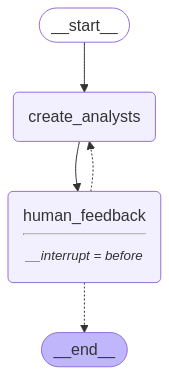

In [6]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph as an agent framework. Her primary interest lies in how LangGraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate with existing technologies and its potential to streamline AI development processes.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Global AI Ethics Consortium
Role: Ethical AI Advocate
Description: Mr. Patel is dedicated to exploring the ethical implications of adopting new AI frameworks like LangGraph. He is interested in how LangGraph can promote transparency and accountability in AI systems. His concerns include ensuring that the framework supports ethical AI practices and does not inadvertently introduce biases or ethical dilemmas.
--------------------------------------------------
Name: M

In [8]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [9]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00af6d-8875-6b5f-8002-6345e9af5d35'}}

In [10]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph as an agent framework. Her primary interest lies in how LangGraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate with existing technologies and its potential to streamline AI development processes.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Global AI Ethics Consortium
Role: Ethical AI Advocate
Description: Mr. Patel is dedicated to exploring the ethical implications of adopting new AI frameworks like LangGraph. He is interested in how LangGraph can promote transparency and accountability in AI systems. His concerns include ensuring that the framework supports ethical AI practices and does not inadvertently introduce biases or ethical dilemmas.
--------------------------------------------------
Name: M

In [11]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00af6f-4ccd-69b2-8004-75de686d8a30'}}

In [12]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [14]:
final_state.next

()

In [15]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Alex Johnson
Affiliation: Tech Innovators Inc.
Role: Startup Entrepreneur
Description: Alex is a startup founder who is keen on leveraging cutting-edge technologies to gain a competitive edge. His focus is on how adopting LangGraph can streamline operations, reduce costs, and enhance product offerings. He is particularly interested in the scalability and flexibility of LangGraph for rapid prototyping and deployment in a startup environment.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: Global Tech Solutions
Role: AI Research Scientist
Description: Dr. Chen is an AI research scientist with a focus on agent-based systems. Her interest in LangGraph revolves around its potential to advance AI research through improved agent communication and collaboration. She is concerned with the technical capabilities of LangGraph, such as its support for complex agent interactions and its integration with existing AI models.
---------------------------------

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [16]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [17]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [18]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [19]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [20]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

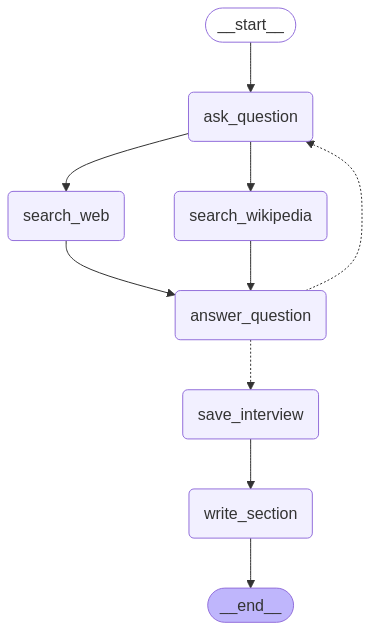

In [21]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [22]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Alex Johnson', role='Startup Entrepreneur', description='Alex is a startup founder who is keen on leveraging cutting-edge technologies to gain a competitive edge. His focus is on how adopting LangGraph can streamline operations, reduce costs, and enhance product offerings. He is particularly interested in the scalability and flexibility of LangGraph for rapid prototyping and deployment in a startup environment.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [23]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Leveraging LangGraph for Startup Success: Streamlining Operations and Enhancing Product Offerings

### Summary

In the fast-paced world of startups, leveraging cutting-edge technologies is crucial for gaining a competitive edge. LangGraph, a powerful tool for natural language processing and AI agent orchestration, offers significant advantages for startups looking to streamline operations, reduce costs, and enhance product offerings. This report explores the scalability and flexibility of LangGraph, particularly in the context of rapid prototyping and deployment, which are essential for startup success.

LangGraph's integration with AI agents creates a synergy that enhances the capabilities of both technologies. AI agents, designed to perform tasks autonomously, benefit from LangGraph's structured framework for natural language processing and understanding. This combination allows for more efficient and effective communication between AI systems and users, driving greater ROI for startups [1]. The community-driven development of LangGraph ensures that it remains at the forefront of AI advancements, with rapid improvements and best practices shared among developers [1].

One of the standout features of LangGraph is its ability to manage multiple AI agents through a divide-and-conquer approach. This capability is particularly beneficial for startups tackling complex problems, as it allows for efficient problem-solving using graphs, nodes, and edges [2]. The flexibility of LangGraph supports various architectures and large language model (LLM) types, making it versatile for different applications [3].

LangGraph's event-driven architecture promotes flexibility and scalability, allowing startups to handle variable loads without overwhelming the system. This architecture ensures that changes in one framework do not impact others, making the system easier to maintain and adapt to changing needs [4]. By leveraging LangGraph for workflow orchestration, startups can enhance efficiency, reduce errors, and improve overall productivity, leading to a greater ROI [4].

The open-source nature of LangGraph, combined with active community support, facilitates easy prototyping and rapid iteration on ideas. This is crucial for startups that need to test and refine their concepts quickly to stay ahead in the market [3]. The collaborative environment fostered by LangGraph's community also provides startups with access to a wealth of knowledge and resources, further accelerating development and innovation [3].

In summary, LangGraph offers a robust solution for startups looking to leverage AI and natural language processing technologies. Its scalability, flexibility, and community-driven development make it an ideal choice for rapid prototyping and deployment, ultimately helping startups streamline operations, reduce costs, and enhance their product offerings.

### Sources
[1] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[2] https://www.reddit.com/r/LangChain/comments/1eh0ly3/spoke_to_22_langgraph_devs_and_heres_what_we_found/  
[3] https://myscale.com/blog/langchain-langgraph-langsmith-game-changers-now/  
[4] https://www.rapidinnovation.io/post/how-to-integrate-langgraph-with-autogen-crewai-and-other-frameworks  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [24]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

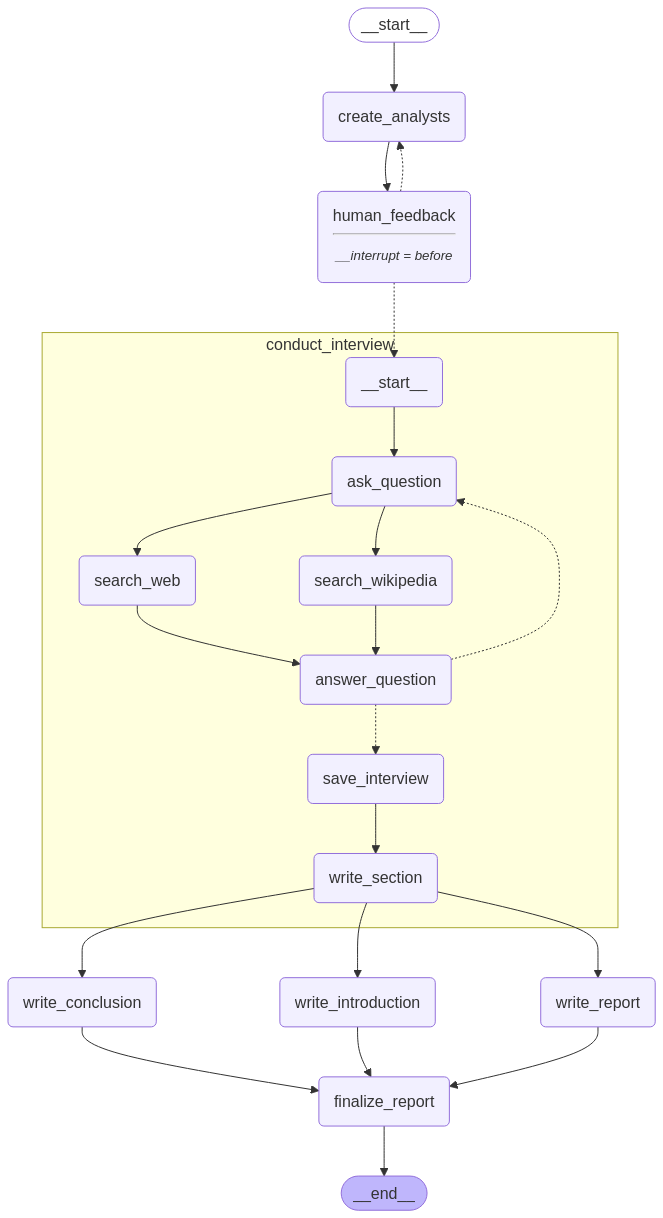

In [25]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [26]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and provide a competitive edge to organizations. Her analysis often includes case studies and data-driven insights to support the adoption of innovative frameworks.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Cybersecurity Analyst
Description: Mr. Patel is concerned with the security implications of adopting new frameworks such as LangGraph. His focus is on evaluating the security features of LangGraph, assessing potential vulnerabilities, and ensuring that the framework complies with industry standards and best practices. He aims to provide a comprehensive risk assessment for organizations considering LangGraph.
------------------

In [27]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00af96-bcb5-6328-8002-503e3c0a54d7'}}

In [28]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and provide a competitive edge to organizations. Her analysis often includes case studies and data-driven insights to support the adoption of innovative frameworks.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Cybersecurity Analyst
Description: Mr. Patel is concerned with the security implications of adopting new frameworks such as LangGraph. His focus is on evaluating the security features of LangGraph, assessing potential vulnerabilities, and ensuring that the framework complies with industry standards and best practices. He aims to provide a comprehensive risk assessment for organizations considering LangGraph.
------------------

In [29]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00af97-567d-69ad-8004-6c258da2d840'}}

In [30]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [31]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Embracing LangGraph: A New Era in AI Frameworks

## Introduction

In the dynamic world of AI development, the quest for frameworks that enhance efficiency and scalability is relentless. LangGraph, introduced in January 2024, emerges as a transformative agent framework built on LangChain, utilizing a Pregel graph structure to redefine AI system architecture. This report explores LangGraph's technical advantages, including its graph-based approach that simplifies complex AI processes and enhances system performance. We delve into its economic and strategic benefits for AI-driven businesses, highlighting its role in maximizing ROI and competitive advantage. Additionally, we examine LangGraph's potential to accelerate innovation in AI-native startups, offering a robust framework for stateful, multi-actor applications.

---



LangGraph, introduced in January 2024, is emerging as a transformative agent framework in the AI landscape, offering significant benefits in terms of efficiency, scalability, and strategic advantage. Built on the LangChain platform, LangGraph utilizes a graph-based approach to redefine AI system architecture, making it particularly advantageous for applications requiring complex node logic and dynamic task handling [1][2]. This framework's graph structure simplifies the understanding and management of agent connections, facilitating the conversion of existing LangChain applications to LangGraph with ease [1].

One of LangGraph's standout features is its support for stateful applications, which is crucial for human-agent collaboration. It incorporates built-in statefulness, Human-in-the-loop Workflows, and first-class streaming support, enabling agents to manage intricate workflows involving multiple agents and cyclical processes [2]. This flexibility is further enhanced by LangGraph's advanced memory management capabilities, which include short-term, long-term, and entity memory, allowing agents to maintain context across interactions and support adaptive decision-making [3].

LangGraph's ability to execute multiple tasks in parallel significantly boosts efficiency, making it ideal for high-performance applications [4]. Its user-friendly interface and risk management capabilities enhance user experience and operational efficiency, leading to increased ROI and improved customer satisfaction, particularly in industries like trading where real-time feedback is crucial [3]. Major enterprises such as LinkedIn, Uber, Klarna, and GitLab have already adopted LangGraph, demonstrating its effectiveness in real-world applications [2].

For AI-native startups, LangGraph offers a robust framework for building stateful, multi-actor applications with large language models (LLMs), enhancing product development and innovation [1]. Its visual representation of workflows promotes efficient cross-functional teamwork among developers, data scientists, and domain experts [2]. However, startups must navigate challenges related to managing long-term memory and ensuring efficient agent interactions to fully leverage LangGraph's capabilities [4].

In summary, LangGraph represents a significant advancement in AI system development, offering a comprehensive solution for enhancing efficiency, scalability, and strategic advantage. Its graph-based architecture, stateful capabilities, and advanced memory management make it a compelling choice for developers and businesses seeking to build intelligent, adaptable, and real-world-ready AI systems. Despite the challenges, LangGraph's innovative features position it as a key player in the next level of AI application development.


---

## Conclusion

LangGraph emerges as a transformative agent framework, offering significant advancements in AI system efficiency and scalability. By leveraging a graph-based architecture, LangGraph simplifies complex AI processes, enhances system performance, and supports stateful applications, making it ideal for intricate workflows. Its advanced memory management and parallel task execution further boost efficiency, providing a robust foundation for AI-driven businesses. Major enterprises have already adopted LangGraph, reaping economic and strategic benefits. For startups, LangGraph accelerates innovation and product development, despite its complexity. Overall, LangGraph stands as a powerful tool for developers and businesses seeking to harness AI's full potential.

## Sources
[1] https://arize.com/blog-course/llm-agent-how-to-set-up/comparing-agent-frameworks/  
[2] https://www.getzep.com/ai-agents/langchain-agents-langgraph/  
[3] https://www.galileo.ai/blog/mastering-agents-langgraph-vs-autogen-vs-crew  
[4] https://medium.com/@Shamimw/langgraph-simplified-how-to-build-ai-workflows-the-smart-way-791c17749663  
[5] https://developer.ibm.com/articles/awb-comparing-ai-agent-frameworks-crewai-langgraph-and-beeai  
[6] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[7] https://www.langchain.com/langgraph  
[8] https://oyelabs.com/langgraph-vs-crewai-vs-openai-swarm-ai-agent-framework/  
[9] https://www.linkedin.com/pulse/behind-scenes-langgraph-innovating-multi-agent-ai-amulya-a-l-i-o-n--0yvbc  
[10] https://www.linkedin.com/pulse/langgraph-challenges-opportunities-multi-agent-riyaz-jaleel-ja3wc

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r